<a href="https://colab.research.google.com/github/EdCsDsIA/TRAB_PRACTICO_MLEARNING/blob/main/REGRESION_LOGISITCA_ACCIDENTES_VIALES_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TRABAJO PRÁCTICO SOBRE CLUSTERIZACION:

GRUPO FORMADO POR:

    GIOVINE, CARINA;
    HERRERO RIVERO, EDUARDO;
    ARÉVALO, IVÁN;
    GÓMEZ, OCTAVIO.
    



## Ejemplo en python de segmentación de clientes de un banco, tomando el saldo de su cuenta y cuantas veces utilizó la tarjeta de débito asociada a dicha cuenta:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Importamos las librerias necesarias
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot') or plt.style.use('ggplot')
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')
import numpy as np

In [3]:
# Creamnos un dataframe con el saldo de algunas cuentas bancarias y el nro de 
# operaciones con la tarjeta de débito asociada a cada una de esas cuentas:
# clientes = pd.DataFrame({"saldo" : [50000, 45000, 48000, 43500, 47000, 52000, 
#                                     20000, 26000, 25000, 23000, 21400, 18000,
#                                     8000, 12000, 6000, 14500, 12600, 7000,
#                                     36000, 34500, 31800, 55000, 33200, 56700,
#                                     9000, 19600, 10100,5950, 24000,16500],
                         
#                          "transacciones": [25, 20, 16, 23, 25, 18,
#                                            23, 22, 24, 21, 27, 18,
#                                            8, 3, 6, 4, 9, 23,
#                                            20, 11, 7, 18, 20, 17,
#                                            19,16,15,21,14,13]})


# # KMeans se ve afectado cuando los datos están en escalas diferentes, por lo que
# # normalizaremos todos los valores del dataframe a una escala de 0 a 1 y asi evitamos
# # introducir un sesgo. De esta forma, conservamos la información, teniendo todos 
# # los datos en una misma escala:
# escalador = MinMaxScaler().fit(clientes.values)

# clientes = pd.DataFrame(escalador.transform(clientes.values),
#                        columns=["saldo", "transacciones"])

# # Vemos como quedó el dataframe luego del escalado:
# print("Así queda el dataframe despues de pasar por el escalador:\n ")
# print(clientes)

In [4]:
# #CODIFICACIÓN DE DATOS CATEGORICOS CATEGORICAS A NUM
# from sklearn.preprocessing import LabelEncoder, OneHotEncoder
# labelencoder_X_1 = LabelEncoder()
# X[:,1] = labelencoder_X_1.fit_transform(X[:,1])

# array([[619, 0, 'Female', ..., 1, 1, 101348.88],
# [608, 2, 'Female', ..., 0, 1, 112542.58],
# [502, 0, 'Female', ..., 1, 0, 113931.57],
# ...,
# [709, 0, 'Female', ..., 0, 1, 42085.58],
# [772, 1, 'Male', ..., 1, 0, 92888.52],
# [792, 0, 'Female', ..., 1, 0, 38190.78]], dtype=object)

In [3]:
# LEER CSV
accidentes = pd.read_csv('/content/drive/MyDrive/IA_TP/TP_ACCIDENTES_VIALES_MEDELLIN/dfinal3_full_clear.csv')

In [6]:
grav = accidentes['Gravedad_victima']

# Sexo = accidentes['Sexo']

In [7]:
accidentes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235843 entries, 0 to 235842
Data columns (total 22 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Gravedad_victima     235843 non-null  int64  
 1   Fecha_incidente      235843 non-null  object 
 2   Hora_incidente       235843 non-null  object 
 3   Clase_incidente      235843 non-null  int64  
 4   Direccion_incidente  235831 non-null  object 
 5   Sexo                 235843 non-null  object 
 6   Edad                 235843 non-null  int64  
 7   Condicion            235843 non-null  object 
 8   Mes                  235843 non-null  object 
 9   Dia                  235843 non-null  object 
 10  Num_dia              235842 non-null  float64
 11  Hora                 235843 non-null  int64  
 12  Grupo_edad           235843 non-null  object 
 13  Anio                 235843 non-null  int64  
 14  Radicado             235794 non-null  float64
 15  Latitud          

Al set de datos lo vamos a preparar distinto.
* Vamos a **ELIMINAR** la columna Anio, Radicando, Latitud y Longitud
  * **ANIO** = Es una variable incremental y puede confundir al algoritmo. no deberia ser motivo para evaluar
  * **Randicando** = Es el aid del accidente no aporta informacion sobre las condiciones de la prediccion.
  * **Latitud** y **Longitud**, los valores se diferencian en decimales. Se debe tomar una desicion, Eliminar las columnas, o probar con los decimales. aporta a la gravedad ya que identifican naturalmente una ubicacion geografica. pero rompe los odd
* Columna HORA, vamos a **crear una columna categorica nueva MOMENTO_DI**A, donde vamos a determinar, MADRUGADA (00-06), MAÑANA(07-11), MEDIODIA(12-13), SIESTA(14-16), TARDE(17-20), NOCHE(21-23), determinado por las hs.
* Columna NUM_DIAS, vamos a **crear una columna categorica nueva SEMANA**, donde vamos a determinar, SEMANA1 (1-7), SEMANA2 (7-14), SEMANA3 (15-21), SEMANA4 (22-31).



In [4]:
# AGREGO LA COLUMNA MOMENTO_DIA
conditionlist = [
    (accidentes['Hora'] >= 00) & (accidentes['Hora'] < 7),
    (accidentes['Hora'] >= 7) & (accidentes['Hora'] < 12),
    (accidentes['Hora'] >= 12) & (accidentes['Hora'] < 14),
    (accidentes['Hora'] >= 14) & (accidentes['Hora'] < 17),
    (accidentes['Hora'] >= 17) & (accidentes['Hora'] < 21),
    (accidentes['Hora'] >= 21)]
choicelist = ['MADRUGADA', 'MANANA', 'MEDIODIA','SIESTA','TARDE','NOCHE']
accidentes['MOMENTO_DIA'] = np.select(conditionlist, choicelist, default='Not Specified')

In [6]:
# AGREGO LA COLUMNA MOMENTO_DIA
conditionlist = [
    (accidentes['Num_dia'] >= 1) & (accidentes['Num_dia'] < 8),
    (accidentes['Num_dia'] >= 8) & (accidentes['Num_dia'] < 15),
    (accidentes['Num_dia'] >= 15) & (accidentes['Num_dia'] < 22),
    (accidentes['Num_dia'] >= 22)]
choicelist = ['SEMANA1', 'SEMANA2', 'SEMANA3','SEMANA4']
accidentes['SEMANA'] = np.select(conditionlist, choicelist, default='Not Specified')

In [8]:
# CONVIERTO LA CATEGORICA Condicion

from sklearn import preprocessing
# instancio la funcion 
le = preprocessing.LabelEncoder()
# unique string
le.fit(accidentes['SEMANA'])
new_col = le.transform(accidentes['SEMANA'])
accidentes=accidentes.assign(Semana_int=new_col)

In [10]:
le = preprocessing.LabelEncoder()
# unique string
le.fit(accidentes['MOMENTO_DIA'])
new_col = le.transform(accidentes['MOMENTO_DIA'])
accidentes=accidentes.assign(MOMENTO_DIA_int=new_col)

In [11]:
accidentes

,Gravedad_victima,Fecha_incidente,Hora_incidente,Clase_incidente,Direccion_incidente,Sexo,Edad,Condicion,Mes,Dia,...,Longitud,Comuna,Barrio,Condicion2,Dia2,Sexo2,MOMENTO_DIA,SEMANA,Semana_int,MOMENTO_DIA_int
0,0,2014-01-01,00:15:00,4,CR 49 CL 72,M,17,Motociclista,Ene,Mie,...,-75.559099,04 - Aranjuez,Manrique Central No. 1,3,4,1,MADRUGADA,SEMANA1,1,0
1,0,2014-01-01,00:30:00,0,CR 46 CL 98,M,20,Motociclista,Ene,Mie,...,-75.553292,01 - Popular,MoscÃº No. 2,3,4,1,MADRUGADA,SEMANA1,1,0
2,0,2014-01-01,00:30:00,0,CR 46 CL 98,F,18,Peaton,Ene,Mie,...,-75.553292,01 - Popular,MoscÃº No. 2,5,4,0,MADRUGADA,SEMANA1,1,0
3,0,2014-01-01,00:37:00,0,CL 32 CR 84,M,19,Motociclista,Ene,Mie,...,-75.607611,16 - BelÃ©n,Las Mercedes,3,4,1,MADRUGADA,SEMANA1,1,0
4,0,2014-01-01,00:37:00,0,CL 32 CR 84,M,39,Peaton,Ene,Mie,...,-75.607611,16 - BelÃ©n,Las Mercedes,5,4,1,MADRUGADA,SEMANA1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235838,0,2021-09-30,22:00:00,4,CL 54 CR 9 A,M,32,Motociclista,Sept,Jue,...,-75.536311,08 - Villa Hermosa,Las Estancias,3,1,1,NOCHE,SEMANA4,4,3
235839,0,2021-09-30,22:00:00,4,CL 54 CR 9 A,F,29,Acompaniante de Motocicleta,Sept,Jue,...,-75.536311,08 - Villa Hermosa,Las Estancias,0,1,0,NOCHE,SEMANA4,4,3
235840,0,2021-09-30,22:00:00,1,CL 81 CR 39,M,41,Acompaniante de Motocicleta,Sept,Jue,...,-75.548675,03 - Manrique,Santa InÃ©s,0,1,1,NOCHE,SEMANA4,4,3
235841,0,2021-09-30,23:00:00,0,CR 63 CL 32,F,51,Peaton,Sept,Jue,...,NaN,Sin Inf,NaN,5,1,0,NOCHE,SEMANA4,4,3


In [12]:
# df3 = accidentes[['Gravedad_victima','Sexo','Edad']]
# df[['Latitud', 'Longitud']]
import numpy as np
# CREA UN DF CON SOLO LOS DATOS np.number (numeros)
df_number = accidentes.select_dtypes(include=[np.number])
# CREA UN DF CON SOLO LOS DATOS objet (strings)
df_object = accidentes.select_dtypes(include=[object])

In [17]:
# GUARDO LOS DF para trabajarlos a posteriori
df_number.to_csv('/content/drive/MyDrive/IA_TP/TP_ACCIDENTES_VIALES_MEDELLIN/df_number.csv')
df_object.to_csv('/content/drive/MyDrive/IA_TP/TP_ACCIDENTES_VIALES_MEDELLIN/df_object.csv')

In [18]:
df_number

,Gravedad_victima,Clase_incidente,Edad,Num_dia,Hora,Anio,Radicado,Latitud,Longitud,Condicion2,Dia2,Sexo2,Semana_int,MOMENTO_DIA_int
0,0,4,17,1.0,0,2014,1423940.0,6.266915,-75.559099,3,4,1,1,0
1,0,0,20,1.0,0,2014,1423921.0,6.289353,-75.553292,3,4,1,1,0
2,0,0,18,1.0,0,2014,1423921.0,6.289353,-75.553292,5,4,0,1,0
3,0,0,19,1.0,0,2014,1423849.0,6.234327,-75.607611,3,4,1,1,0
4,0,0,39,1.0,0,2014,1423849.0,6.234327,-75.607611,5,4,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235838,0,4,32,30.0,22,2021,1764135.0,6.234267,-75.536311,3,1,1,4,3
235839,0,4,29,30.0,22,2021,1764135.0,6.234267,-75.536311,0,1,0,4,3
235840,0,1,41,30.0,22,2021,1763968.0,6.272697,-75.548675,0,1,1,4,3
235841,0,0,51,30.0,23,2021,1764133.0,NaN,NaN,5,1,0,4,3


In [19]:
# BUSCO LAS COLUMNAS CON NAN
df_number.isnull().sum()

Gravedad_victima        0
Clase_incidente         0
Edad                    0
Num_dia                 1
Hora                    0
Anio                    0
Radicado               49
Latitud             20845
Longitud            20845
Condicion2              0
Dia2                    0
Sexo2                   0
Semana_int              0
MOMENTO_DIA_int         0
dtype: int64

In [20]:
# df_number = pd.read_csv('/content/drive/MyDrive/IA_TP/TP_ACCIDENTES_VIALES_MEDELLIN/df_number.csv')
# ELIMINO TODAS LAS FILAS NAN
df_number_no_nan = df_number.dropna()

In [13]:
# df_number_no_nan2 = np.all(np.isfinite(df_number_no_nan2))

In [22]:
# df_number_no_nan.isnull().sum()
df_number_no_nan_2 = df_number_no_nan.drop(['Anio','Radicado','Latitud','Longitud' ], axis=1)

In [24]:
df_number_no_nan_2.to_csv('/content/drive/MyDrive/IA_TP/TP_ACCIDENTES_VIALES_MEDELLIN/df_number_no_nan_2.csv')
df_number_no_nan_2

,Gravedad_victima,Clase_incidente,Edad,Num_dia,Hora,Condicion2,Dia2,Sexo2,Semana_int,MOMENTO_DIA_int
0,0,4,17,1.0,0,3,4,1,1,0
1,0,0,20,1.0,0,3,4,1,1,0
2,0,0,18,1.0,0,5,4,0,1,0
3,0,0,19,1.0,0,3,4,1,1,0
4,0,0,39,1.0,0,5,4,1,1,0
...,...,...,...,...,...,...,...,...,...,...
235836,0,4,44,30.0,20,3,1,0,4,5
235837,0,2,38,30.0,20,3,1,0,4,5
235838,0,4,32,30.0,22,3,1,1,4,3
235839,0,4,29,30.0,22,0,1,0,4,3


In [16]:
# df_number_escalado

## REGRESION LOGISTICA SOBRE EL DF_NUMBER_NO_NAN

In [17]:
# PASOS
# 1- AL SET DE DATOS HAY QUE SACARLE LA COLUMNA Y (GAVEDAD DE VICTIMA) y CREAR UN DATAFREAM CON EL VECTOR Y
# DF_X = TODOS LOS CAMPOS MENOS Y
# DF_Y = SOLO LA COLUMNA GRAVEDAD VICTIMA
# 1.a  - GRAFICAR COLUMNAS
# 2- REALIZAR EL SPLIT
# 3- ENTRENAR
# 4- PREDECIR
# 5- METRICAS

## ARMO LA MATRIZ X & EL VECTOR Y

In [25]:
# 1 ARMAR MATRIZ X y VECTOR Y
y = df_number_no_nan_2['Gravedad_victima']
X = df_number_no_nan_2.drop(['Gravedad_victima'], axis=1)
print(y)
print(X)


0         0
1         0
2         0
3         0
4         0
         ..
235836    0
235837    0
235838    0
235839    0
235840    0
Name: Gravedad_victima, Length: 214952, dtype: int64
        Clase_incidente  Edad  Num_dia  Hora  Condicion2  Dia2  Sexo2  \
0                     4    17      1.0     0           3     4      1   
1                     0    20      1.0     0           3     4      1   
2                     0    18      1.0     0           5     4      0   
3                     0    19      1.0     0           3     4      1   
4                     0    39      1.0     0           5     4      1   
...                 ...   ...      ...   ...         ...   ...    ...   
235836                4    44     30.0    20           3     1      0   
235837                2    38     30.0    20           3     1      0   
235838                4    32     30.0    22           3     1      1   
235839                4    29     30.0    22           0     1      0   
235840      

## SPLIT DEL DATASET

In [26]:
# 2- REALIZAR EL SPLIT
# train a logistic regression model on the training set

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.30)


## CREO EL MODELO Y ENTRENO

In [27]:
# 3- ENTRENAR
# CREO EL MODELO
logreg = LogisticRegression(solver='liblinear', random_state=0)
# ENTRENO EL MODELO CON LOS DF SPLITEADOS
logreg.fit(X_train, y_train)

LogisticRegression(random_state=0, solver='liblinear')

In [28]:
# Reviso la influencia de cada columna
# Equivale a la matriz de pesos.
print(logreg.coef_)

[[-0.44825805  0.02509171  0.0158453   0.02847566  0.1083726  -0.03456827
   0.53568287 -0.12069952 -0.18432894]]


# 4 - PREDECIR

In [29]:
# 4- PREDECIR
# ESTA ES LA PREDICCION
y_pred_test = logreg.predict(X_test)
#SALIDA DE LA PREDICCION
y_pred_test

array([0, 0, 0, ..., 0, 0, 0])

## 5 - METRICAS

In [30]:
# 5- METRICAS

# CALCULO LA PRESICION DEL ALGORITMO DE PREDICCION COMPARANDO EL Y DE SALIDA REAL VS LA PREDICCION
# La métrica accuracy representa el porcentaje total de valores correctamente
from sklearn.metrics import accuracy_score

# FUNCION DE CALCULO DE SCORE
# accuracy_score(y_test, y_pred_test)

print('Model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_pred_test)))
# Vemos las puntuaciones en el conjunto de entrenamiento y prueba: desde el modelo
print('Training set score: {:.4f}'.format(logreg.score(X_train, y_train)))
print('Test set score:     {:.4f}'.format(logreg.score(X_test, y_test)))

Model accuracy score: 0.9911
Training set score: 0.9917
Test set score:     0.9911


Confusion matrix

 [[63911     0]
 [  575     0]]

True Positives(TP) =  63911

True Negatives(TN) =  0

False Positives(FP) =  0

False Negatives(FN) =  575


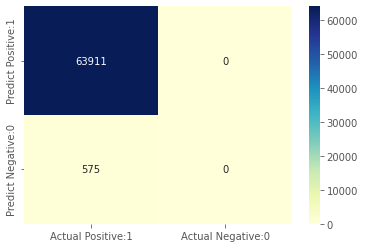

In [31]:
# Creamos nuestra Matriz de Confusión:
# COMPARANDO EL Y DE SALIDA REAL VS LA PREDICCION
import seaborn as sns # statistical data visualization
%matplotlib inline
# import category_encoders as ce

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_test)
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

# Visualizamos la Matriz de Confusión:
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [32]:
# El Informe de Clasificación es otra forma de evaluar el rendimiento del modelo de clasificación.
# Muestra las puntuaciones de precisión, recuperación, f1 y soporte para el modelo:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_test))
# aqui se observa que variable tiene mayor influencia
print("coef",logreg.coef_)

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     63911
           1       0.00      0.00      0.00       575

    accuracy                           0.99     64486
   macro avg       0.50      0.50      0.50     64486
weighted avg       0.98      0.99      0.99     64486

coef [[-0.44825805  0.02509171  0.0158453   0.02847566  0.1083726  -0.03456827
   0.53568287 -0.12069952 -0.18432894]]


In [33]:
# y.loc[y[0]==0].count()
# y.describe()
y.value_counts()

0    213131
1      1821
Name: Gravedad_victima, dtype: int64

In [34]:
a = 5*10+0.000005*10000000
print(a)


100.0


In [55]:
from math import e
r = 1 / (1+e**(a))
r

3.7200759760208555e-44

## SUPUESTOS DE LA REGRESION LOGISTICA
REGRESION LOGISTICA: la variable de respuesta es binaria [0,1]

In [35]:
# EVALUO LA SALIDA (OUTPUT) DEBE TENER  2 VALORES
# la funcion unique de la libreria numpy nos permite leer un array de numpy y su salida son valores unicos
# https://numpy.org/doc/stable/reference/generated/numpy.unique.html
print(np.unique(y))
# EVALUO LA CANTIDAD DE VALORES QUE HAY PARA CADA UNO
df_y = pd.DataFrame(y)
df_y.groupby(['Gravedad_victima']).size()

[0 1]


Gravedad_victima
0    213131
1      1821
dtype: int64

## SUPUESTO 2 - Linealidad de variables independientes y probabilidades logarítmicas

REGRESION LOGISTICA: Existe una relación lineal entre las variables explicativas y el logit de la variable de respuesta
## **FUNCION LOGIT**

* La función logit es una parte importante de la regresión logística
**En matemáticas, especialmente aquellas aplicadas en estadística, el logit de un número p entre 0 y 1 es**

La base de la función logaritmo usada aquí es de poca importancia, siempre y cuando **sea mayor que 1**, aunque se usa a menudo el logaritmo natural con base e.

**La función logit es la inversa del "sigmoide", o función "logística".**

* Si p es una probabilidad entonces p/(1 − p) es la razón de momios, y el logit de la probabilidad es el logaritmo de la razón de momios; 
* **La diferencia entre los logits de dos probabilidades es el logaritmo del odds ratio (OR), obteniéndose así un mecanismo aditivo para combinar odds-ratios.**

### LOGARITMO DE ODD

In [36]:
# VAMOS A CONVERTIR LA MATRIZ DE NP a UN DF 
df = pd.DataFrame(X)

# CREAMOS UNA COPIA DEL DF ORIGINAL PARA NO ALTERAR EL ORIGINAL
df_lt = df.copy()  # lt = logit transform

# Add logit transform interaction terms (natural log) for continuous variables e.g. Age * Log(Age)
for var in df_lt.columns:
    df_lt[f'{var}:Log_{var}'] = df_lt[var].apply(lambda x: x * np.log(x)) #np.log = natural log

df_lt.head()
# ESTA FUNCION GENERA COLUMNAS NUEVAS POR CADA UNA DE LAS VARIABLES SU LOGARITMO DE OD PARA PODER VER SU LINEALIDAD
# DEBE SER LINEAL LA VARIABLE DE INTERES (INDEPENDIENTE) CON RESPECTO A SU LOGARITMO DE ODD ( se calcula la variable * logaritmo de si mismo)

,Clase_incidente,Edad,Num_dia,Hora,Condicion2,Dia2,Sexo2,Semana_int,MOMENTO_DIA_int,Clase_incidente:Log_Clase_incidente,Edad:Log_Edad,Num_dia:Log_Num_dia,Hora:Log_Hora,Condicion2:Log_Condicion2,Dia2:Log_Dia2,Sexo2:Log_Sexo2,Semana_int:Log_Semana_int,MOMENTO_DIA_int:Log_MOMENTO_DIA_int
0,4,17,1.0,0,3,4,1,1,0,5.545177,48.164627,0.0,NaN,3.295837,5.545177,0.0,0.0,NaN
1,0,20,1.0,0,3,4,1,1,0,NaN,59.914645,0.0,NaN,3.295837,5.545177,0.0,0.0,NaN
2,0,18,1.0,0,5,4,0,1,0,NaN,52.026692,0.0,NaN,8.047190,5.545177,NaN,0.0,NaN
3,0,19,1.0,0,3,4,1,1,0,NaN,55.944341,0.0,NaN,3.295837,5.545177,0.0,0.0,NaN
4,0,39,1.0,0,5,4,1,1,0,NaN,142.878904,0.0,NaN,8.047190,5.545177,0.0,0.0,NaN


In [28]:
list(df_lt.columns)

['Clase_incidente',
 'Edad',
 'Num_dia',
 'Hora',
 'Anio',
 'Radicado',
 'Latitud',
 'Longitud',
 'Condicion2',
 'Dia2',
 'Sexo2',
 'Clase_incidente:Log_Clase_incidente',
 'Edad:Log_Edad',
 'Num_dia:Log_Num_dia',
 'Hora:Log_Hora',
 'Anio:Log_Anio',
 'Radicado:Log_Radicado',
 'Latitud:Log_Latitud',
 'Longitud:Log_Longitud',
 'Condicion2:Log_Condicion2',
 'Dia2:Log_Dia2',
 'Sexo2:Log_Sexo2']

In [37]:
df_lt.isnull().sum()

Clase_incidente                            0
Edad                                       0
Num_dia                                    0
Hora                                       0
Condicion2                                 0
Dia2                                       0
Sexo2                                      0
Semana_int                                 0
MOMENTO_DIA_int                            0
Clase_incidente:Log_Clase_incidente    36963
Edad:Log_Edad                           2814
Num_dia:Log_Num_dia                        0
Hora:Log_Hora                           3333
Condicion2:Log_Condicion2              32522
Dia2:Log_Dia2                          25344
Sexo2:Log_Sexo2                        65924
Semana_int:Log_Semana_int                  0
MOMENTO_DIA_int:Log_MOMENTO_DIA_int    32175
dtype: int64

In [39]:
df_lt_no_nan = df_lt.dropna() 

ValueError: ignored

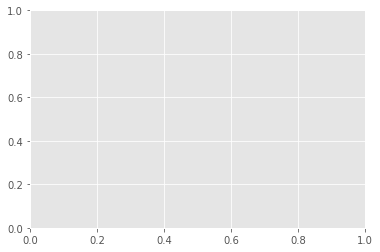

In [46]:
plt.hist(df_lt_no_nan['MOMENTO_DIA_int'])

NO GRAFICA x NULOS

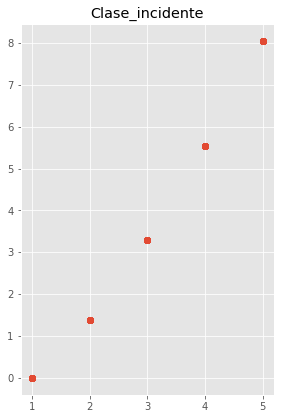

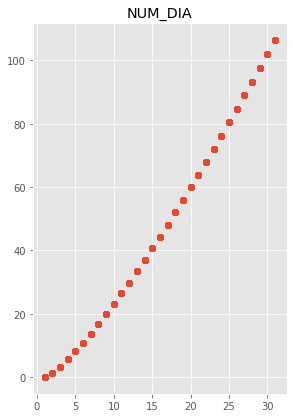

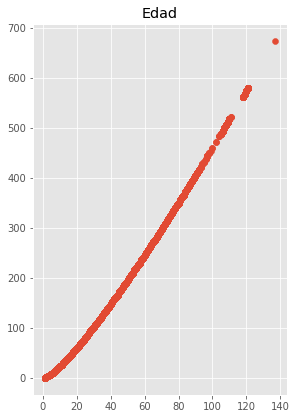

In [42]:
# GRAFICO LAS COLUMNAS PARA OBSERVAR SU LINEALIDAD
plt.figure(figsize = (10,15))

plt.subplot(2,2,1)

plt.title ('Clase_incidente')
plt.scatter(df_lt['Clase_incidente'],df_lt['Clase_incidente:Log_Clase_incidente'])

plt.figure(figsize=(10,15))
plt.subplot(2,2,2)
plt.title ('NUM_DIA')
plt.scatter(df_lt['Num_dia'],df_lt['Num_dia:Log_Num_dia'])

plt.figure(figsize=(10,15))
plt.subplot(2,2,3)
plt.title ('Edad')
plt.scatter(df_lt['Edad'],df_lt['Edad:Log_Edad'])

plt.figure(figsize=(10,15))
plt.subplot(2,2,3)
plt.title ('Edad')
plt.scatter(df_lt['Edad'],df_lt['Edad:Log_Edad'])

# plt.subplot(2,2,4)
# plt.title ('Hora')
# plt.scatter(df_lt[2],df_lt['Hora:Log_Hora'])

# plt.subplot(2,3,1)
# plt.title ('Anio')
# plt.scatter(df_lt[2],df_lt['Anio:Log_Anio'])

In [ ]:
df_lt.head